In [1]:
import torch
print(torch.__version__)

from datasets.dataset import RandomPatchFromFolder
from utils.visualization import visualize_one, visualize_pairs, visualize_triplets
from models.blocks import Generator, Discriminator, FeatureExtractor, ConvBlock, UpConvBlock
import torchvision
from os.path import join, exists
from os import mkdir

from utils.metrics import psnr
from utils import utils
# %pylab inline
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

0.4.1


In [2]:
import torch.utils.data as data_utils
import torch
from os import listdir
from os.path import join
import imageio
import numpy as np
from PIL import Image
from torchvision.transforms import RandomCrop, Resize


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


class DatasetFromFolder(data_utils.Dataset):
    def __init__(self, image_dir):
        super(DatasetFromFolder, self).__init__()
        self.image_dir = image_dir
        self.image_filenames = [x for x in listdir(image_dir) if is_image_file(x)]

    def __getitem__(self, index):
        return Image.fromarray(imageio.imread(join(self.image_dir, self.image_filenames[index])))

    def __len__(self):
        return len(self.image_filenames)


class RandomPatchFromFolder(data_utils.Dataset):
    def __init__(self, image_dir, patch_size=64, cr=2, normalize=False, **kwargs):
        super(RandomPatchFromFolder, self).__init__()
        self.normalize = normalize
        
        self.dataset_from_folder = DatasetFromFolder(image_dir)
        self.cropper = RandomCrop(size=patch_size*cr)
        self.resizer = Resize(size=patch_size)

    @staticmethod
    def to_tensor(patch, normalize=True):
        tensor = torch.Tensor(np.asarray(patch).swapaxes(0, 2)).float()
        if normalize:
            tensor = (tensor / 255 - 0.5) * 2
        return tensor
        
    @staticmethod
    def to_image(tensor, denormalize=True):
        if isinstance(tensor, torch.Tensor):
            tensor = tensor.numpy()

        if len(tensor.shape) == 4:
            tensor = tensor.swapaxes(1, 3)
        elif len(tensor.shape) == 3:
            tensor = tensor.swapaxes(0, 2)
        else:
            raise Exception("Predictions have shape not in set {3,4}")
            
        if denormalize:
            tensor = (tensor / 2 + 0.5) * 255
            tensor[tensor > 255] = 255
            tensor[tensor < 0] = 0
            
        return tensor.round().astype(int)

    def __getitem__(self, index):
        img = self.dataset_from_folder[index]

        hr_patch = self.cropper(img)
        lr_patch = self.resizer(hr_patch)
        return self.to_tensor(lr_patch, self.normalize), self.to_tensor(hr_patch, self.normalize)

    def __len__(self):
        return len(self.dataset_from_folder)


In [3]:
import torch
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

class Stats(object):
    '''
        Contains 
            > train batch numbers
            > test batch numbers
            > max, mean, std, min train errors 
            > max, mean, std, min test  errors 
            
            > max, mean, std, min train metrics 
            > max, mean, std, min test  metrics 
    '''
    def __init__(self):
        self.plotname = 'plot.png'

    def set_output_directory(self, output_directory):
        self.output_directory = output_directory
        
    stats = dict(
        errors = dict(
            train=list(),
            test=list()
        ),
        metrics = dict(
            train=list(),
            test=list()        
        )    
    )
    
    @staticmethod
    def compute_stats(batch):
        return torch.min(batch), torch.max(batch), torch.mean(batch), torch.std(batch)
    
    def add_set_stats(self, set_, batch_errs, batch_metrics):
        self.stats['errors'][set_].append(self.compute_stats(batch_errs))
        self.stats['metrics'][set_].append(self.compute_stats(batch_metrics))
        
    def add_stats(self, 
                  train_batch_errors=None, train_batch_metrics=None,
                  test_batch_errors=None, test_batch_metrics=None):
        if train_batch_errors and train_batch_metrics:
            self.add_set_stats('train', train_batch_errors, train_batch_metrics)
        if test_batch_errors and test_batch_metrics:
            self.add_set_stats('test', test_batch_errors, test_batch_metrics)
    
    def plot_value_set_stats(self, axis, value, set_):
        mins, maxs, means, stds = tuple(zip(*self.stats[value][set_]))
        axis.set_title(f'{set_} {value}')
        iters = np.arange(len(self.stats[value][set_]))
        axis.plot(iters, maxs, label=f'Max batch {value}')
        axis.plot(iters, means, label=f'Mean batch {value}') # errorbar
        axis.plot(iters, mins, label=f'Min batch {value}')
        axis.legend(loc='best')
        
    def plot(self, description):
        clear_output(True)
        figure = plt.figure(figsize=(16, 6))

        train_err_ax, test_err_ax = plt.subplot2grid((3,3), (0,0)), plt.subplot2grid((3,3), (0,1))
        train_metric_ax, test_metric_ax = plt.subplot2grid((3,3), (1,0)), plt.subplot2grid((3,3), (1,1))
        
        self.plot_value_set_stats(train_err_ax, 'errors', 'train')
        self.plot_value_set_stats(test_err_ax, 'errors', 'test')
        self.plot_value_set_stats(train_metric_ax, 'metrics', 'train')
        self.plot_value_set_stats(test_metric_ax, 'metrics', 'test')
        
        text_plot = plt.subplot2grid((3,3), (0, 2), rowspan=2)
        last_min, last_max, last_mean, last_std = self.stats['errors']['train'][-1]
        description = f'''
        {description}
        Min err: {last_min:2f}
        Max err: {last_max:2f}
        Mean err: {last_mean:2f}
        Std err: {last_std:2f} 
        '''
        text_panel = AnchoredText(description, loc='center')
        text_plot.add_artist(text_panel)
        
        text_plot.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labeltop=False,
            labelleft=False,
            labelright=False,
        )

        for tl in text_plot.spines.values():
            tl.set_visible(False)
        
        plt.tight_layout()
        plt.pause(0.05)
        if self.output_directory:
            figure.savefig(join(self.output_directory, self.plotname))
        plt.show()
        

In [4]:
class BasicSR(torch.nn.Module):
    def __init__(self, *sequence):
        super(BasicSR, self).__init__()
        self.model = torch.nn.Sequential(*sequence)
        self.model.train()
        
    def forward(self, x):
        x = self.model.forward(x)
        return x

    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            x = self.model.forward(x)
        self.model.train()
        return x.detach().cpu()

In [5]:
import torch
import torch.nn.functional as F

class Model(object):
    '''
        Builds Net object and Stats object 
    '''
    def __init__(self, net, device='cpu'):
        self.device = device
        self.net = net.to(device)
        self.criterion = torch.nn.MSELoss(reduction='none').to(device)
        self.optimizer = torch.optim.Adam(net.parameters())
        
        self.stats = Stats()
        
        self.metric = lambda x: x # define metric 
        
    def set_output_directory(self, output_directory):
        self.output_directory = output_directory
        self.stats.set_output_directory(output_directory)
    
    @staticmethod
    def load(self):
        pass
    
    def save(self,):
        torch.save(
            {
                'net': self.net,
                'optimizer': self.optimizer,
            }, 
            join(self.output_directory, "net_and_optimizer.pt")
        )
    
    def train_on_batch(self, lr, hr, set_='train', add_stats=True):
        self.optimizer.zero_grad()
        
        batch_lr = lr.to(self.device)
        batch_hr = hr.to(self.device)
        
        predicted_hr = self.net.forward(batch_lr)

        raw_criterion = self.criterion(predicted_hr, batch_hr)
        average_picture_criterion = F.avg_pool3d(raw_criterion, raw_criterion.shape[1:]).flatten()
        
        loss = torch.mean(average_picture_criterion)
        loss.backward()
        self.optimizer.step()
        
        average_picture_criterion = average_picture_criterion.detach().cpu()
        if add_stats:
            self.stats.add_set_stats(
                set_,
                batch_errs=average_picture_criterion, 
                batch_metrics=self.metric(average_picture_criterion)
            )
    
    def evaluate_on_batch(self, lr, hr, set_='test', add_stats=True):       
        with torch.no_grad():
            batch_lr = lr.to(self.device)
            batch_hr = hr.to(self.device)

            predicted_hr = self.net.forward(batch_lr)

            raw_criterion = self.criterion(predicted_hr, batch_hr)
            average_picture_criterion = F.avg_pool3d(raw_criterion, raw_criterion.shape[1:]).flatten()

            average_picture_criterion = average_picture_criterion.detach().cpu()
            if add_stats:
                self.stats.add_set_stats(
                    set_,
                    batch_errs=average_picture_criterion, 
                    batch_metrics=self.metric(average_picture_criterion)
                )
            
    def plot(self, description):
        self.stats.plot(description)
    
    def predict(self, data):
        return self.net.forward(data)
    

In [6]:
class Experiment(object):   

    default_experiment_parameters = dict(                       
        output_prefix = 'data/experiments/',
        epochs = 2,
    )
    
    default_dataloader_parameters = dict(
        pin_memory = True,
        shuffle = True,
        batch_size = 16,
        num_workers = 4
    )
    
    def __init__(self, exp_name, model, dataset, validation, seed=1,  
                 update_experiment_parameters=None, update_dataloader_parameters=None):
        self.exp_name = exp_name
        self.dataset = dataset
        self.validation = validation
        self.seed = seed

        self.experiment_parameters = {**self.default_experiment_parameters, **(update_experiment_parameters or {})}
        self.dataloader_parameters = {**self.default_dataloader_parameters, **(update_dataloader_parameters or {})}

        self._setup_dataloader(self.dataloader_parameters)
        self._setup_output_directory()
        self._setup_model(model)
        
        self.reset_epochs()
    
    def _setup_output_directory(self):
        if not exists(join(self.experiment_parameters.get('output_prefix'), self.exp_name)):
            mkdir(join(self.experiment_parameters.get('output_prefix'), self.exp_name))
    
    def reset_epochs(self):
        self.epochs_left = self.experiment_parameters.get('epochs')
        
    def _setup_dataloader(self, params):
        self.dataloader = torch.utils.data.DataLoader(self.dataset, **params)
        
    def _setup_model(self, model):               
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)

        self.model = model
        self.model.set_output_directory(join(self.experiment_parameters.get('output_prefix'), self.exp_name))

    def train(self):
        epochs = self.experiment_parameters.get('epochs')
        for epoch in range(epochs - self.epochs_left, epochs):
            for i, (batch_lr, batch_hr) in enumerate(self.dataloader):
                self.model.train_on_batch(batch_lr, batch_hr, set_='train', add_stats=(i % 5 == 0))
                if i % 25 == 0:
                    lr, hr = self.validation
                    self.model.evaluate_on_batch(lr, hr, 'test', add_stats=True)
                self.model.plot(self.description(epoch*len(self.dataloader) + i))
                self.model.save()
            self.epochs_left -= 1

    def description(self, batch_number):
        description = f'''
        ********** Batch {batch_number} ************
        '''
        return description
    
#     def to_dict(self):
#         return { 
#         **self.env_parameters,
#         **self.net_parameters,
#         **self.game_parameters, 
#         **self.advantage_parameters, 
#         "exp_name":self.exp_name,
#         "seed:":self.seed
#         }
    
#     def __repr__(self):
#         return pp_json(self.to_dict(), False)

In [7]:
train_dataset = RandomPatchFromFolder("data/div2k/val")

validation = list(map(lambda tensors: torch.cat(tuple(map(lambda t: t.unsqueeze(0), tensors)), dim=0), 
         zip(*(train_dataset[i] for i in range(10)))))

In [8]:
net = BasicSR(
    ConvBlock(3, 32, 5),
#     ConvBlock(32, 32, 5),
#     ConvBlock(32, 64, 5),
#     ConvBlock(64, 64, 5),
#     ConvBlock(64, 128, 5),
#     ConvBlock(128, 128, 5),
    UpConvBlock(32, 3, upscale=2),
)
model = Model(net, device='cpu')

In [9]:
e = Experiment(
    exp_name='FOOB', 
    dataset=train_dataset,
    validation=validation,
    model=model
)

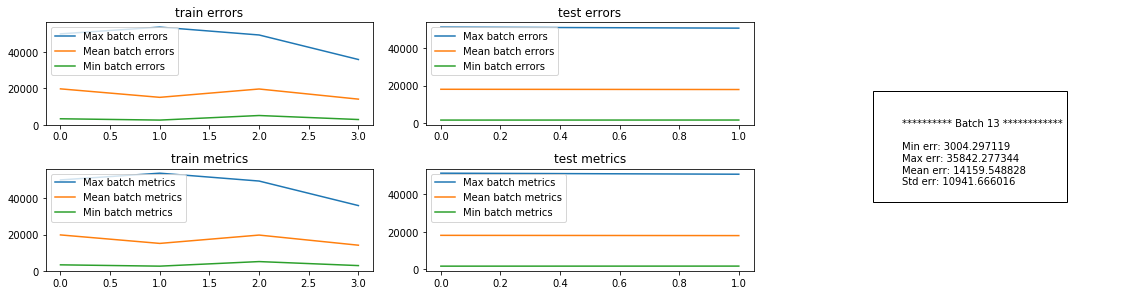

In [10]:
e.train()

In [11]:
# env_name = "CartPole-v0"
# max_path_length = 3000
# n_iter = 100

# for i, num_target_updates in enumerate([1, 10, 100]):
#     for j, num_grad_steps_per_target_update in enumerate([1, 10,100]):
#         e = holder.start_experiment(
#             env_name=env_name, exp_name=f"{env_name}_{3*i+j+1}", 
#             update_net_parameters=dict(
#                 num_target_updates=num_target_updates,
#                 num_grad_steps_per_target_update=num_grad_steps_per_target_update,
#             ),
#             update_game_parameters=dict(
#                 max_path_length=max_path_length,
#             ))
#         e.train_agent(n_iter)